# Characterization of Alzheimer's Disease through clustering of Medical notes

## Introduction

### Importing packages

In [971]:
import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sentence_transformers import SentenceTransformer, util
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from gap_statistic import OptimalK

## Data Pre-processing

### Exploring the data

In [1131]:
path = "data/Early-onset.csv"
df = pd.read_csv(path)
df

,person_id,birth_datetime,gender_source_value,race_source_value,ethnicity_source_value,note_title,note_text
0,271,1932-02-09 00:00:00,FEMALE,WHITE,NOT HISPANIC,order_impression: IMAGING,No acute osseous abnormality of the right shou...
1,271,1932-02-09 00:00:00,FEMALE,WHITE,NOT HISPANIC,order_impression: IMAGING,FINDINGS OF PULMONARY EDEMA. ACUITY LEVEL: 2. ...
2,271,1932-02-09 00:00:00,FEMALE,WHITE,NOT HISPANIC,order_impression: IMAGING,No acute osseous abnormality of the right shou...
3,271,1932-02-09 00:00:00,FEMALE,WHITE,NOT HISPANIC,order_impression: IMAGING,No acute osseous abnormality of the right shou...
4,271,1932-02-09 00:00:00,FEMALE,WHITE,NOT HISPANIC,order_impression: IMAGING,1. Moderate subcutaneous hematoma about the le...
...,...,...,...,...,...,...,...
26182,258985,1946-12-18 00:00:00,FEMALE,WHITE,NOT HISPANIC,order_narative: IMAGING,X-ray abdomen complete with chest Indication: ...
26183,258985,1946-12-18 00:00:00,FEMALE,WHITE,NOT HISPANIC,order_narative: IMAGING,CTA dissection protocol. Technique: Axial imag...
26184,258985,1946-12-18 00:00:00,FEMALE,WHITE,NOT HISPANIC,order_narative: IMAGING,CTA dissection protocol. Technique: Axial imag...
26185,258985,1946-12-18 00:00:00,FEMALE,WHITE,NOT HISPANIC,order_narative: IMAGING,Study: AP radiograph of the chest History: Wea...


### Calculating the age of each patient from their birth date

In [1132]:
# Converting the "birth_datetime" column to a datetime format 
df["birth_datetime"] = pd.to_datetime(df["birth_datetime"], format='%Y-%m-%d')
# Calculating the age by substracting the current date with the date in the dataframe
df["age"] = (pd.Timestamp('now') - df["birth_datetime"]).astype('timedelta64[Y]')
# Converting age to integer
df["age"]  = pd.to_numeric(df["age"], downcast='integer')
# Dropping the birth_datetime (it's useless at this point) 
df = df.drop("birth_datetime", axis=1)
# Re-arranging the order of the columns
df = df[['person_id', 'age', 'gender_source_value', 'race_source_value', 'ethnicity_source_value', 'note_title', 'note_text']]
df

,person_id,age,gender_source_value,race_source_value,ethnicity_source_value,note_title,note_text
0,271,90,FEMALE,WHITE,NOT HISPANIC,order_impression: IMAGING,No acute osseous abnormality of the right shou...
1,271,90,FEMALE,WHITE,NOT HISPANIC,order_impression: IMAGING,FINDINGS OF PULMONARY EDEMA. ACUITY LEVEL: 2. ...
2,271,90,FEMALE,WHITE,NOT HISPANIC,order_impression: IMAGING,No acute osseous abnormality of the right shou...
3,271,90,FEMALE,WHITE,NOT HISPANIC,order_impression: IMAGING,No acute osseous abnormality of the right shou...
4,271,90,FEMALE,WHITE,NOT HISPANIC,order_impression: IMAGING,1. Moderate subcutaneous hematoma about the le...
...,...,...,...,...,...,...,...
26182,258985,75,FEMALE,WHITE,NOT HISPANIC,order_narative: IMAGING,X-ray abdomen complete with chest Indication: ...
26183,258985,75,FEMALE,WHITE,NOT HISPANIC,order_narative: IMAGING,CTA dissection protocol. Technique: Axial imag...
26184,258985,75,FEMALE,WHITE,NOT HISPANIC,order_narative: IMAGING,CTA dissection protocol. Technique: Axial imag...
26185,258985,75,FEMALE,WHITE,NOT HISPANIC,order_narative: IMAGING,Study: AP radiograph of the chest History: Wea...


#### Some statistics on the age of the patients

In [1133]:
df['age'].describe()

count    26187.000000
mean        77.554741
std         11.470307
min         26.000000
25%         67.000000
50%         81.000000
75%         88.000000
max         99.000000
Name: age, dtype: float64

### Creating the corpus from medical notes 

#### Using the note_text column for raw data

In [1134]:
corpus_raw = list(df["note_text"])

#### Removing words that don't contain much meaning from our notes

In [1135]:
words_to_remove = ["Department of Neurosurgery Date of Consult", "Department of Orthopedics Consultation Note Date of Consult", "Geriatric Medicine Consult Date of Consult", "INPATIENT MEDICAL NUTRITION THERAPY", "MSW", "RN" ,"evidence", "Read By", "images", "report", "concur", "findings", "agree", "seen", "residents", "resident", "Resident", "unspecified provider", "Released Date Time", "personally reviewed" ,"D.O", "MD", "M.D.", "Electronically Verified By", "NAME:", "[**NAME**]", "EXAM DATE:", "[**DATE**]", "LOC:", "[**LOCATION_INSTITUTE**]", "[**LOCATION_STREET**]", "[**LOCATION_ZIP**]", "[**LOCATION_CITY**]", "[**CONTACT_PHONE**]", "[**LOCATION_OTHER**]", "MRN:", "[**ID**]", "DOB:", "** VERIFIED **", "ORDERING MD:", "ORDER:", "ORD. SERVICE:", "ORD. LOC:", "TECH", "RMS# / INV#:"]
# words_to_remove = ["NAME:", "[**NAME**]", "EXAM DATE:", "[**DATE**]", "LOC:", "[**LOCATION_INSTITUTE**]", "[**LOCATION_STREET**]", "[**LOCATION_ZIP**]", "[**LOCATION_CITY**]", "[**CONTACT_PHONE**]", "[**LOCATION_OTHER**]", "MRN:", "[**ID**]", "DOB:", "** VERIFIED **", "ORDERING MD:", "ORDER:", "ORD. SERVICE:", "ORD. LOC:", "TECH", "RMS# / INV#:"]

# words_to_remove = words_to_remove + list(STOPWORDS)
corpus_clean = []
for item in corpus_raw:
    for word in words_to_remove:
        item = item.replace(word, '') 
    corpus_clean.append(item)

In [1136]:
df['note_text'].iloc[989]

'IMPRESSION: No acute osseous abnormality. I personally reviewed the images and the residents findings and agree with the above. Read By - [**NAME**] D.O.  Electronically Verified By - [**NAME**] D.O.  Released Date Time - [**DATE**] 9:52 AM  Resident - [**NAME**]'

#### Taking each word from the cleaned corpus and making it lowercase

In [1137]:
corpus = [word.lower() for word in corpus_clean]
corpus[989]

'impression: no acute osseous abnormality. i  the  and the   and  with the above.  -  .   -  .   -  9:52 am   - '

#### Adding the pre-processed version of the notes to the DataFrame

In [1138]:
df["note_text"] = corpus
df

,person_id,age,gender_source_value,race_source_value,ethnicity_source_value,note_title,note_text
0,271,90,FEMALE,WHITE,NOT HISPANIC,order_impression: IMAGING,no acute osseous abnormality of the right shou...
1,271,90,FEMALE,WHITE,NOT HISPANIC,order_impression: IMAGING,findings of pulmonary edema. acuity level: 2. ...
2,271,90,FEMALE,WHITE,NOT HISPANIC,order_impression: IMAGING,no acute osseous abnormality of the right shou...
3,271,90,FEMALE,WHITE,NOT HISPANIC,order_impression: IMAGING,no acute osseous abnormality of the right shou...
4,271,90,FEMALE,WHITE,NOT HISPANIC,order_impression: IMAGING,1. moderate subcutaneous hematoma about the le...
...,...,...,...,...,...,...,...
26182,258985,75,FEMALE,WHITE,NOT HISPANIC,order_narative: IMAGING,x-ray abdomen complete with chest indication: ...
26183,258985,75,FEMALE,WHITE,NOT HISPANIC,order_narative: IMAGING,cta dissection protocol. technique: axial of ...
26184,258985,75,FEMALE,WHITE,NOT HISPANIC,order_narative: IMAGING,cta dissection protocol. technique: axial of ...
26185,258985,75,FEMALE,WHITE,NOT HISPANIC,order_narative: IMAGING,study: ap radiograph of the chest history: wea...


## Creating Text embeddings

In [1139]:
model = SentenceTransformer("../models/sentence_transformers/emilyalsentzer_Bio_ClinicalBERT")

No sentence-transformers model found with name ../models/sentence_transformers/emilyalsentzer_Bio_ClinicalBERT. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at ../models/sentence_transformers/emilyalsentzer_Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from

### Some model parameters

The Transformer itself has a max sequence length of 512 tokens and it does not lowercase the input. For the pooling operation we will produce a 768-dimensional sentence embedding. We do this using mean pooling 

In [1140]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [1141]:
embeddings = model.encode(corpus, show_progress_bar=True)

Batches:   0%|          | 0/819 [00:00<?, ?it/s]

In [1142]:
embeddings

array([[-0.04270806, -0.2722384 ,  0.02541331, ...,  0.14533459,
        -0.0664463 , -0.11730304],
       [ 0.24206899, -0.12554152, -0.11126476, ...,  0.13504232,
        -0.07171036, -0.21101835],
       [-0.04270806, -0.2722384 ,  0.02541331, ...,  0.14533459,
        -0.0664463 , -0.11730304],
       ...,
       [ 0.14000909, -0.24060056,  0.01999374, ...,  0.20956802,
        -0.19258067, -0.10662035],
       [-0.02650105, -0.33855188, -0.09942739, ...,  0.29439577,
        -0.02508109, -0.12649913],
       [ 0.14000909, -0.24060056,  0.01999374, ...,  0.20956802,
        -0.19258067, -0.10662035]], dtype=float32)

In [1143]:
embeddings.shape

(26187, 768)

From the last cell, we see that our embeddings are high-dimensional as they contain several featured (768). To handle this, we use dimensionallity reduction so that we can both visualize and cluster our embeddings.

## Finding the right k

Before performing k means clustering we need to find the exact number K that can optimize our number of cluster. To do so, we will use gap statistic

In [1144]:
TOKENIZERS_PARALLELISM = False
optimalK = OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalK(embeddings, n_refs=50, cluster_array=np.arange(1,10))
print(f"The correct number of clusters is:{num_clusters}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/opt/conda/envs/rapids/lib/python3.9/site-packages/gap_statistic/optimalK.py:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gap_df = gap_df.append(
/opt/conda/envs/rapids/lib/python3.9/site-packages/gap_statistic/optimalK.py:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gap_df = gap_df.append(
/opt/conda/envs/rapids/lib/python3.9/site-packages/gap_statistic/optimalK.py:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gap_df = gap_df.append(
/opt/conda/envs/rapids/lib/python3.9/site-packages/gap_statistic/optimalK.py:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gap_df = gap_df.append(
/opt/conda/envs/rapids/lib/python3.9

In [1145]:
optimalK.gap_df

,n_clusters,gap_value,ref_dispersion_std,sk,gap*,sk*,diff,diff*
0,1.0,1.630148,308.677282,0.000211,1.188461e+06,1.200287e+06,-0.108019,1.200496e+06
1,2.0,1.738387,320.652170,0.000221,1.209453e+06,1.221488e+06,-0.123148,1.221768e+06
2,3.0,1.861758,321.731945,0.000222,1.237634e+06,1.249949e+06,-0.057636,1.250062e+06
3,4.0,1.919698,441.468514,0.000305,1.248902e+06,1.261329e+06,-0.051900,1.261426e+06
4,5.0,1.971882,410.288504,0.000283,1.258663e+06,1.271188e+06,-0.024581,1.271227e+06
5,6.0,1.996758,427.334230,0.000295,1.262666e+06,1.275230e+06,-0.055097,1.275328e+06
6,7.0,2.052112,370.481598,0.000256,1.272530e+06,1.285192e+06,-0.024484,1.285231e+06
7,8.0,2.076848,365.004375,0.000253,1.276406e+06,1.289106e+06,-0.006447,1.289112e+06
8,9.0,2.083527,334.431479,0.000232,1.276976e+06,1.289683e+06,NaN,NaN


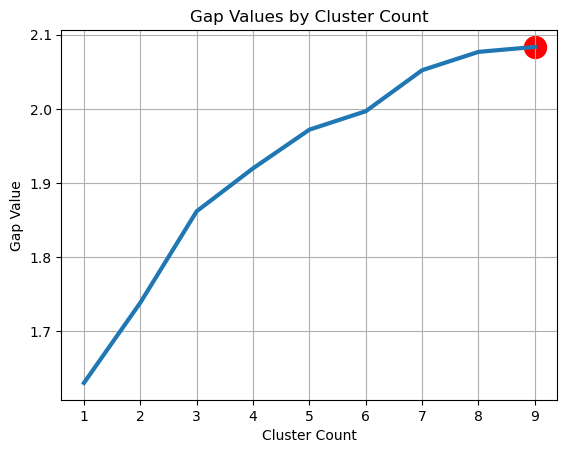

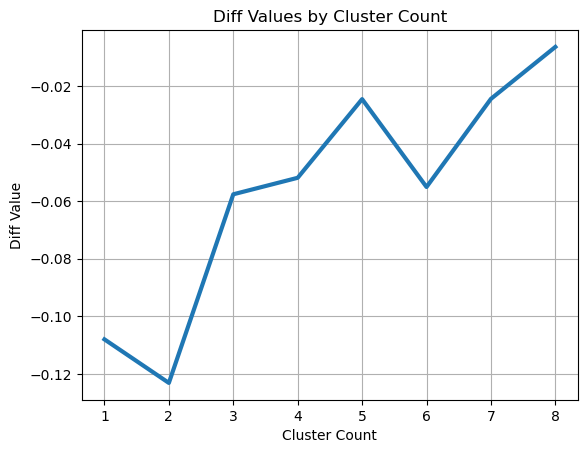

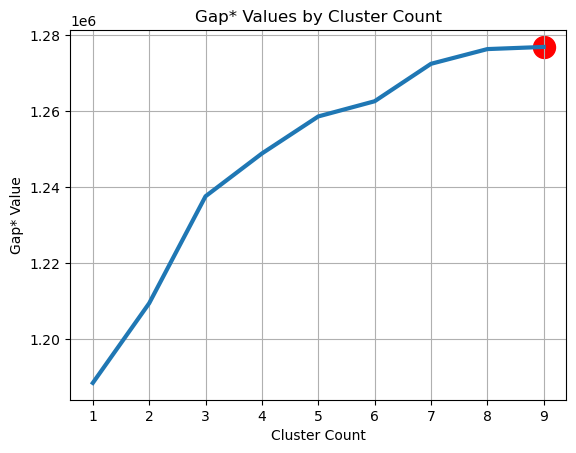

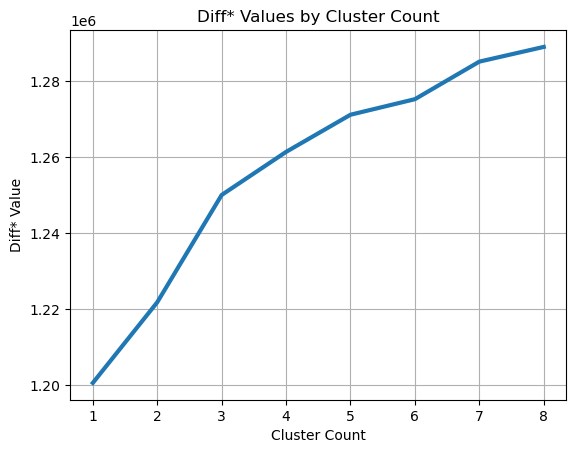

In [1146]:
optimalK.plot_results()

In [1147]:
# Create an empty dictionary to save the within cluster sum of square values
wcss = {} 
# Look through the number of clusters
for i in range(1,10):
  # Run kmeans model
  kmeans = KMeans(n_clusters=i, random_state=0).fit(embeddings)
  #Sum of squared distances of samples to their closest cluster center.
  wcss[i] = (kmeans.inertia_)
  # Print the within cluster sum of squares for each cluster number
  print(f'The within cluster sum of squares for {i} clusters is {wcss[i]}')

The within cluster sum of squares for 1 clusters is 289541.5
The within cluster sum of squares for 2 clusters is 253293.359375
The within cluster sum of squares for 3 clusters is 227704.234375
The within cluster sum of squares for 4 clusters is 214196.578125
The within cluster sum of squares for 5 clusters is 202994.8125
The within cluster sum of squares for 6 clusters is 193675.515625
The within cluster sum of squares for 7 clusters is 186800.34375
The within cluster sum of squares for 8 clusters is 179633.71875
The within cluster sum of squares for 9 clusters is 174113.890625


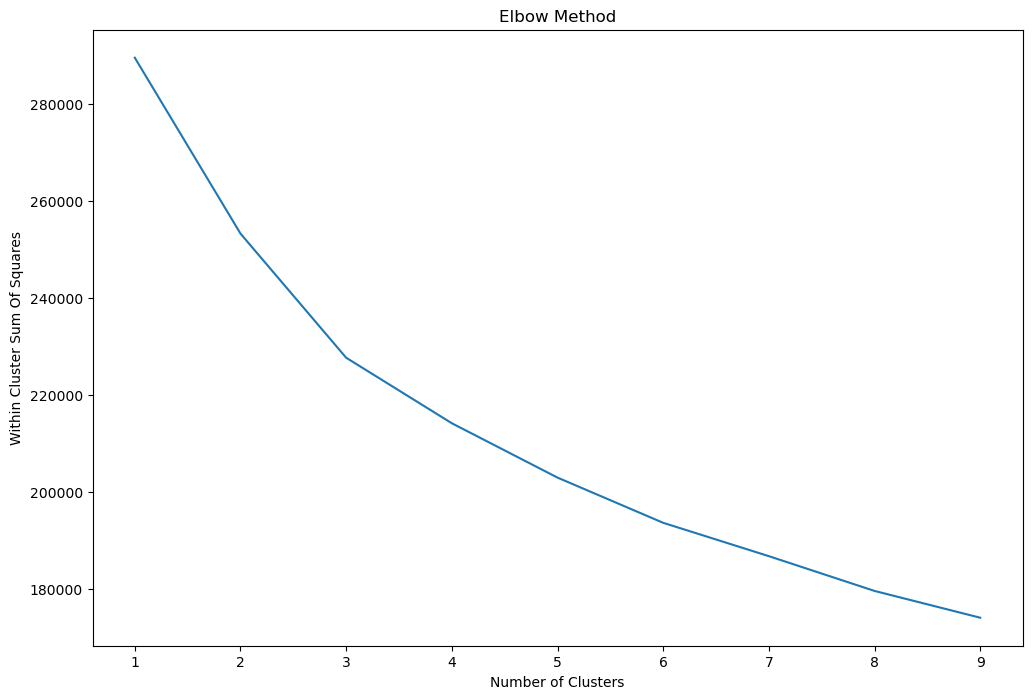

In [1148]:
# Visualization
plt.figure(figsize=(12,8))
plt.plot(list(wcss.keys()),list(wcss.values()))
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')    
plt.ylabel('Within Cluster Sum Of Squares')
plt.show()

## Dimensionality Reduction

In [1149]:
reducer = umap.UMAP(metric="cosine", n_neighbors=num_clusters, n_components=2)
umap_embedding = reducer.fit_transform(embeddings)
umap_embedding.shape

/opt/conda/envs/rapids/lib/python3.9/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/opt/conda/envs/rapids/lib/python3.9/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/opt/conda/envs/rapids/lib/python3.9/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


(26187, 2)

## Clustering with K-means

In [1150]:
cluster = KMeans(n_clusters=num_clusters)
cluster.fit(umap_embedding)
cluster_assignment = cluster.labels_

In [1151]:
print(f"Running K means with {num_clusters} clusters")

Running K means with 9 clusters


### Taking a look at the different categories

In [1152]:
cluster_assignment

array([7, 0, 7, ..., 8, 1, 8], dtype=int32)

### Putting the notes with their clusters for better visualization

In [1153]:
df_corpus = pd.DataFrame({"person_id": df["person_id"], "Corpus": corpus, "Cluster": cluster_assignment})
df_corpus

,person_id,Corpus,Cluster
0,271,no acute osseous abnormality of the right shou...,7
1,271,findings of pulmonary edema. acuity level: 2. ...,0
2,271,no acute osseous abnormality of the right shou...,7
3,271,no acute osseous abnormality of the right shou...,7
4,271,1. moderate subcutaneous hematoma about the le...,0
...,...,...,...
26182,258985,x-ray abdomen complete with chest indication: ...,3
26183,258985,cta dissection protocol. technique: axial of ...,8
26184,258985,cta dissection protocol. technique: axial of ...,8
26185,258985,study: ap radiograph of the chest history: wea...,1


## Data Visualization

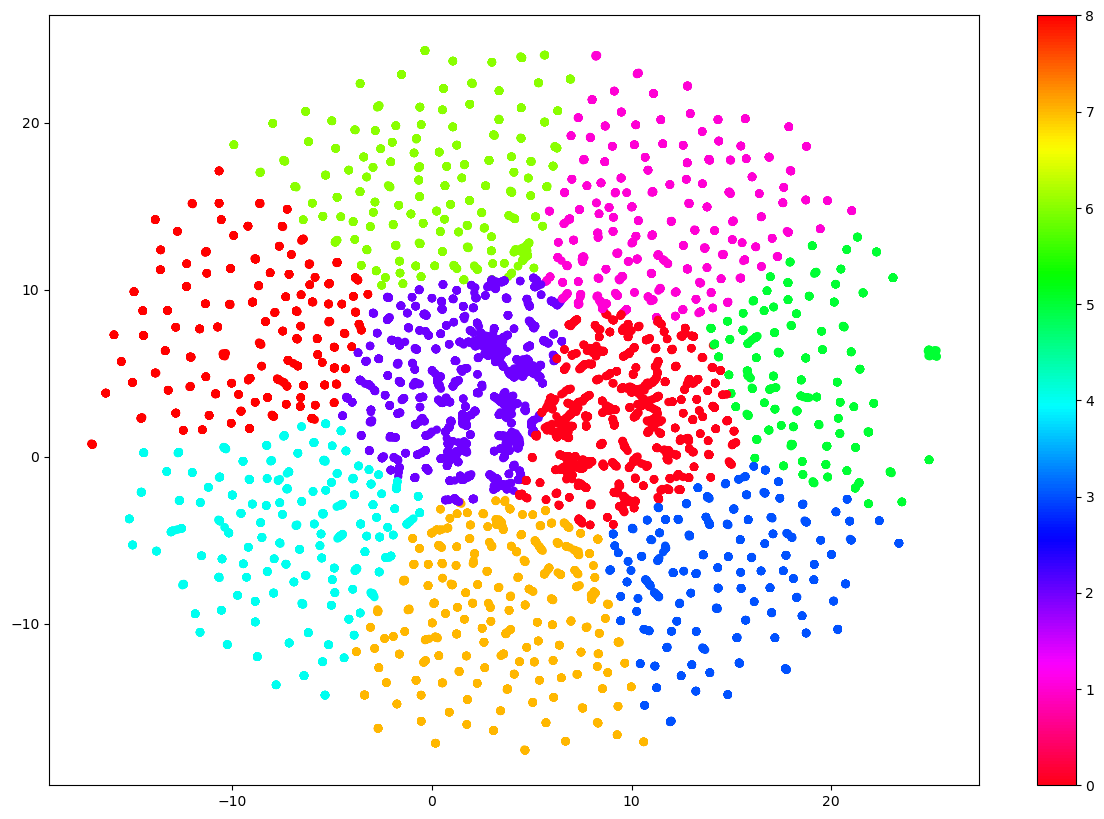

In [1154]:
# Prepare data
result = pd.DataFrame(umap_embedding, columns=['x', 'y'])
result['labels'] = cluster_assignment

# Visualize clusters
fig, ax = plt.subplots(figsize=(15, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=25)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=25, cmap='hsv_r')
plt.colorbar()

In [1155]:
docs_df = pd.DataFrame(corpus, columns=["Doc"])
docs_df['Topic'] = cluster_assignment
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [1156]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(corpus))

In [1157]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=30):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=30)
topic_sizes = extract_topic_sizes(docs_df)
topic_sizes

/opt/conda/envs/rapids/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Topic,Size
2,2,3982
0,0,3606
7,7,3128
1,1,2853
6,6,2754
4,4,2713
8,8,2436
5,5,2368
3,3,2347


In [1158]:
docs_per_topic['Doc']

0    findings of pulmonary edema. acuity level: 2. ...
1    impression: 1. no change from . 2. no radiogra...
2    exam: xr chest 2 views indication: altered men...
3    impression: retraction of the percutaneous cho...
4    history:  need to visualize the whole hand and...
5    internal fixation of right intertrochanteric f...
6    history: acute left ankle pain exam: xr foot l...
7    no acute osseous abnormality of the right shou...
8    procedure: ct guided drainage of perihepatic f...
Name: Doc, dtype: object

In [1159]:
top_n_words

{0: [('acuity', 0.013246536973343206),
  ('non', 0.012320478358844056),
  ('fracture', 0.010967542569164606),
  ('routine', 0.010879254843371643),
  ('rank', 0.010398946792603723),
  ('significantly', 0.008519686951476929),
  ('spine', 0.008457088314972322),
  ('morbidity', 0.008348333092550075),
  ('unlikely', 0.00833994144315897),
  ('pelvis', 0.008322385285233136),
  ('emergent', 0.00831619481902696),
  ('femoral', 0.008309271097918567),
  ('result', 0.00830897648561097),
  ('minor', 0.008305127251181727),
  ('unexpected', 0.008273540882519397),
  ('term', 0.008162937626023695),
  ('changed', 0.008059248244986392),
  ('acute', 0.008054535548450223),
  ('relatively', 0.008038927685551134),
  ('exam', 0.008005709116779764),
  ('known', 0.008001269918053675),
  ('short', 0.0079409170074372),
  ('bilateral', 0.007937166280839505),
  ('degenerative', 0.00792338556373435),
  ('level', 0.007845215787475846),
  ('study', 0.007764520266272529),
  ('xr', 0.0077291380502190745),
  ('findings',

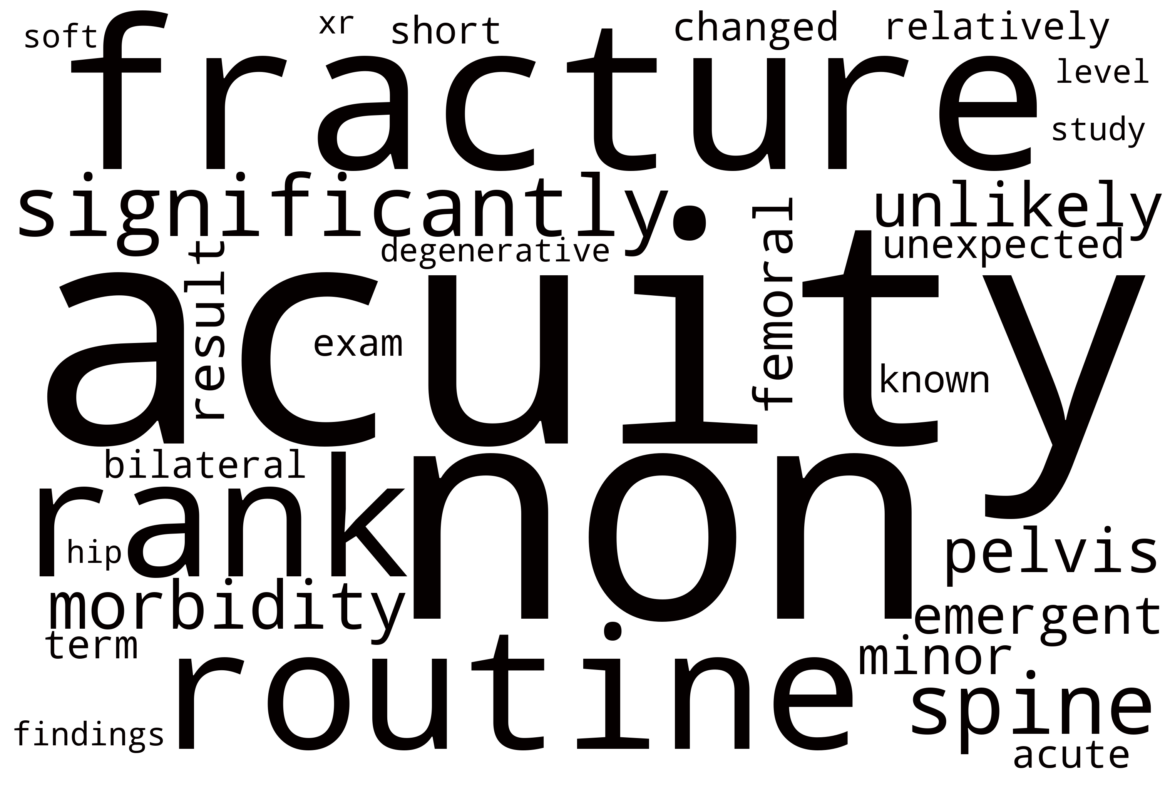

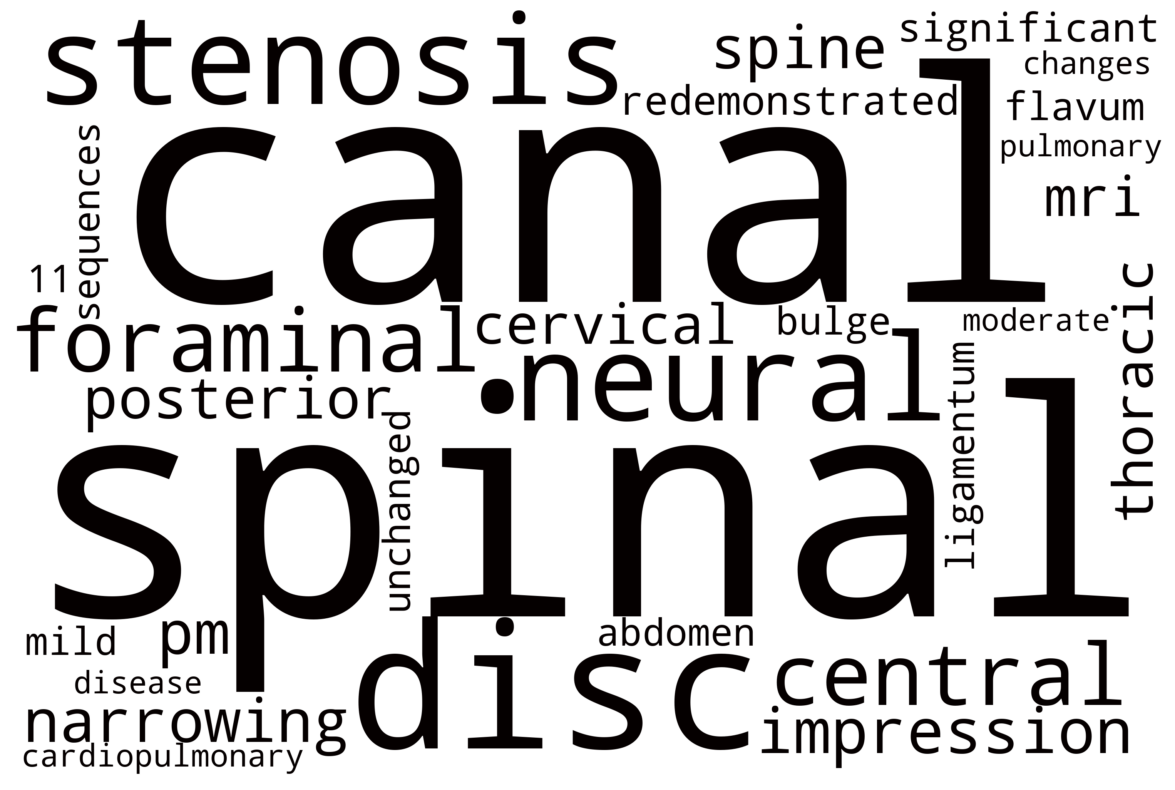

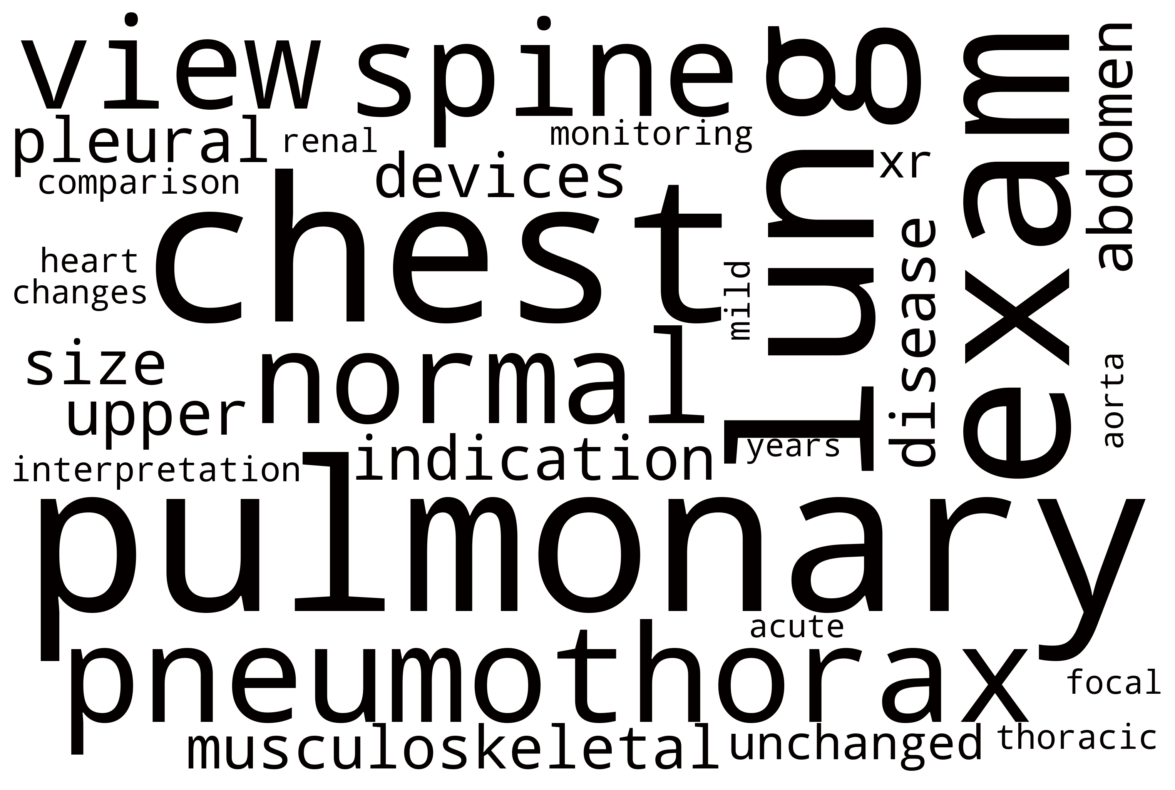

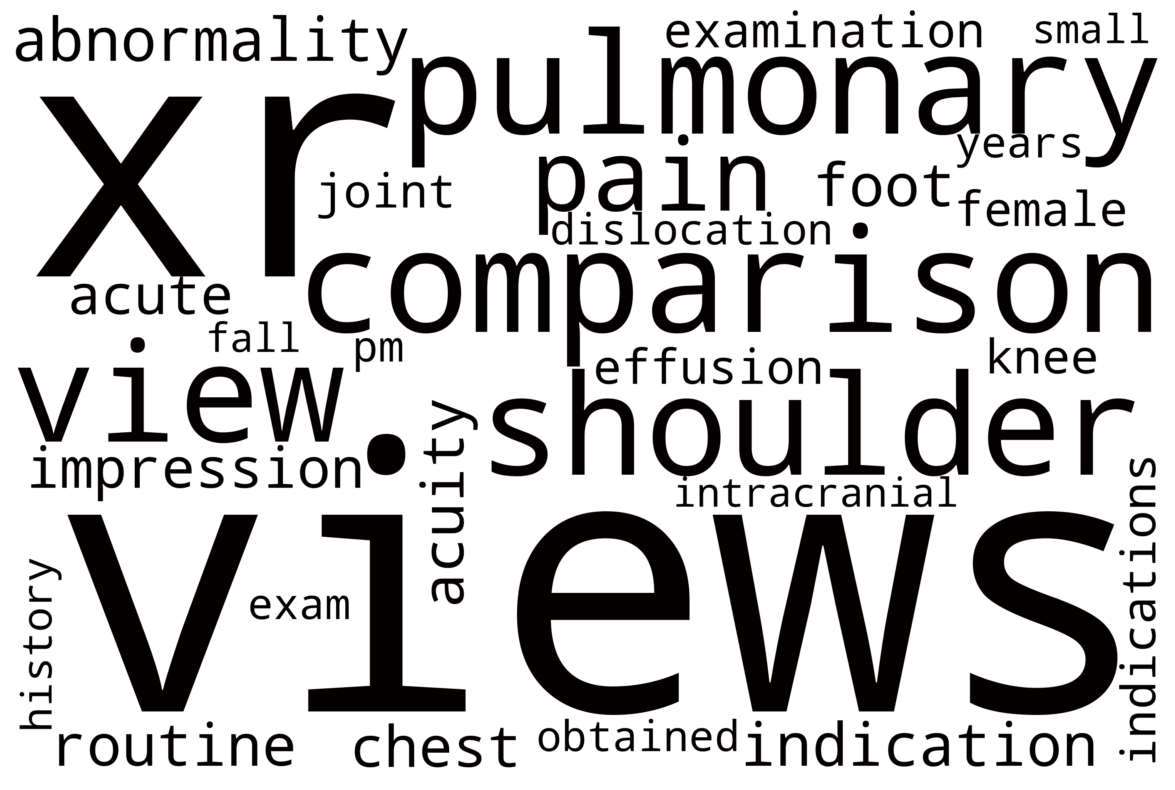

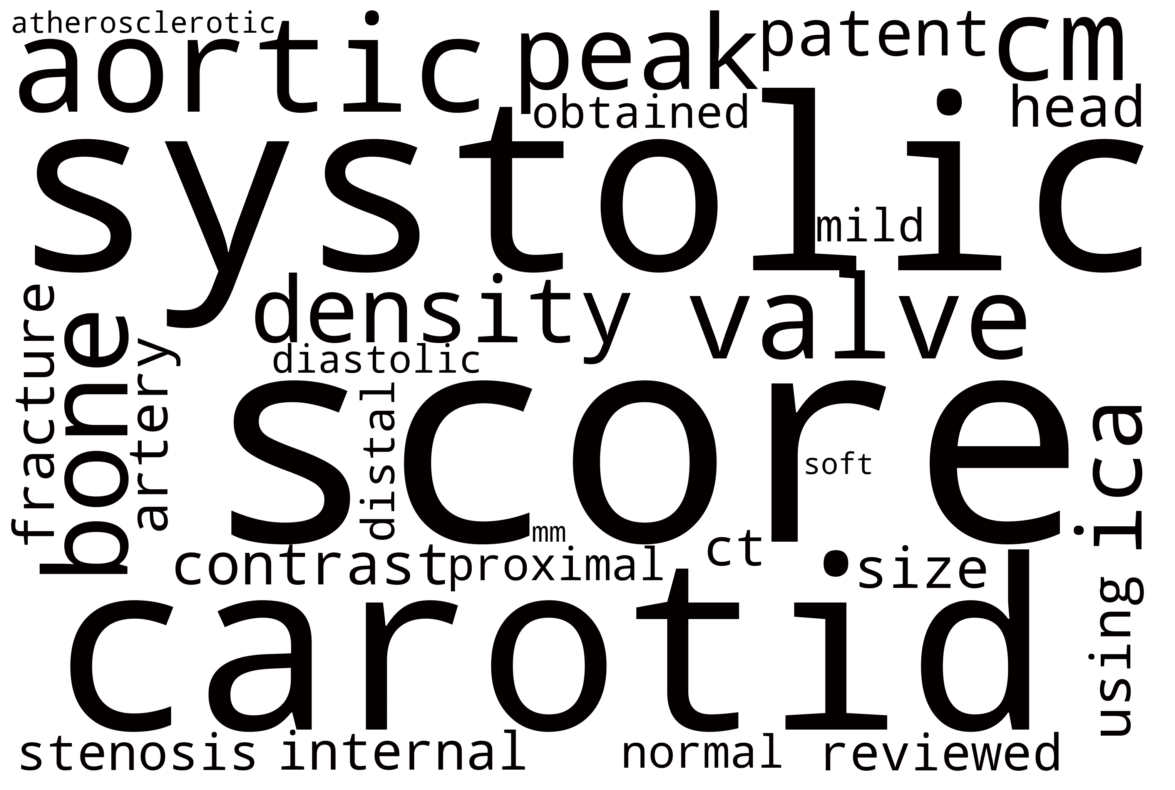

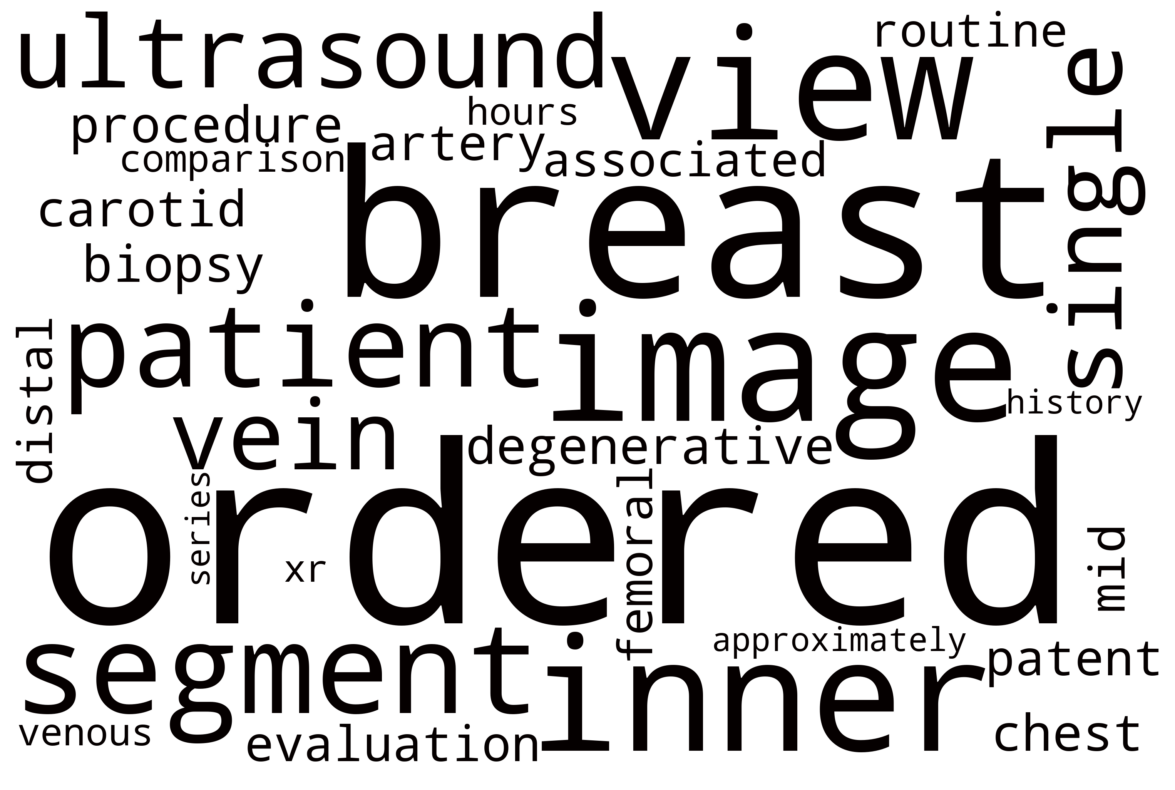

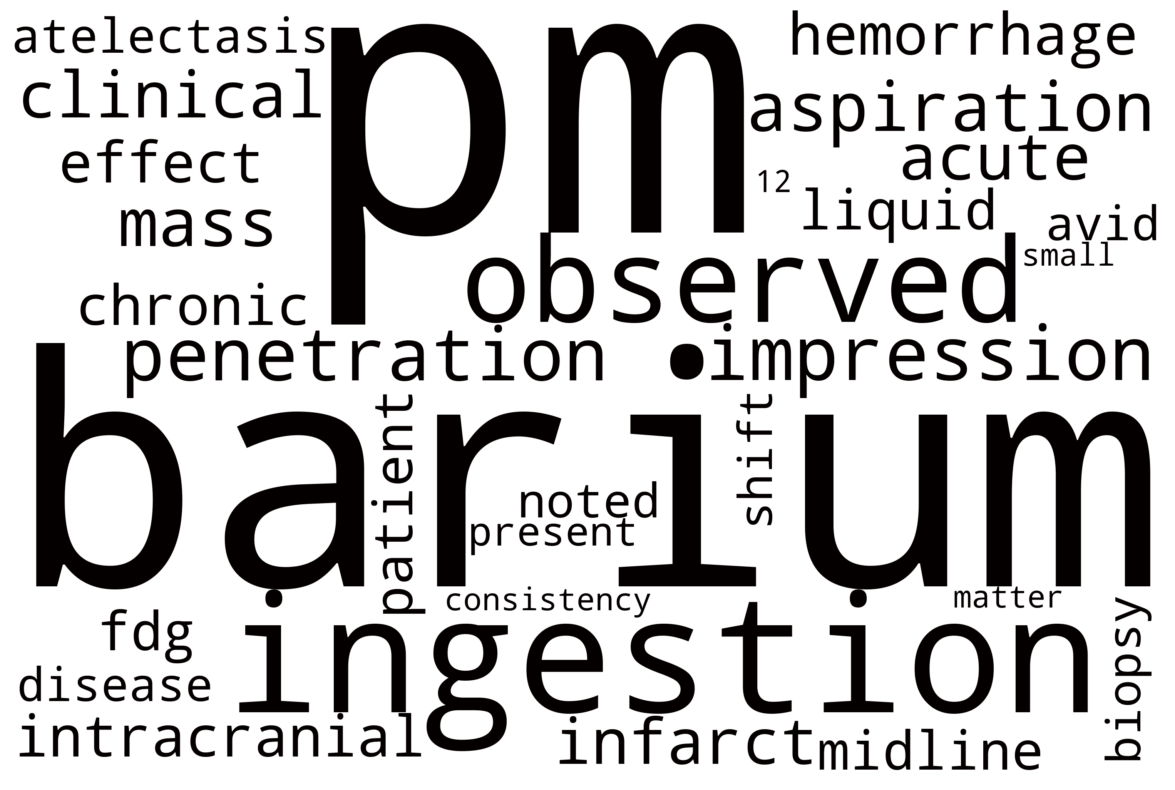

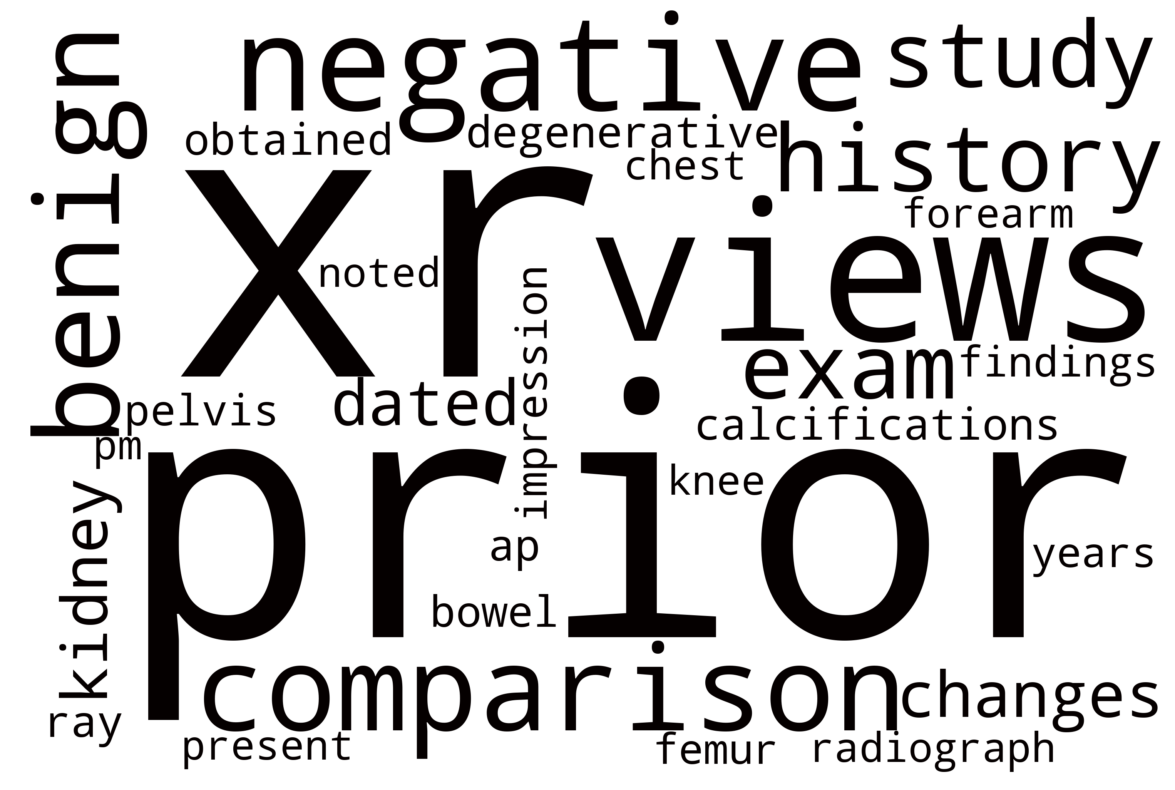

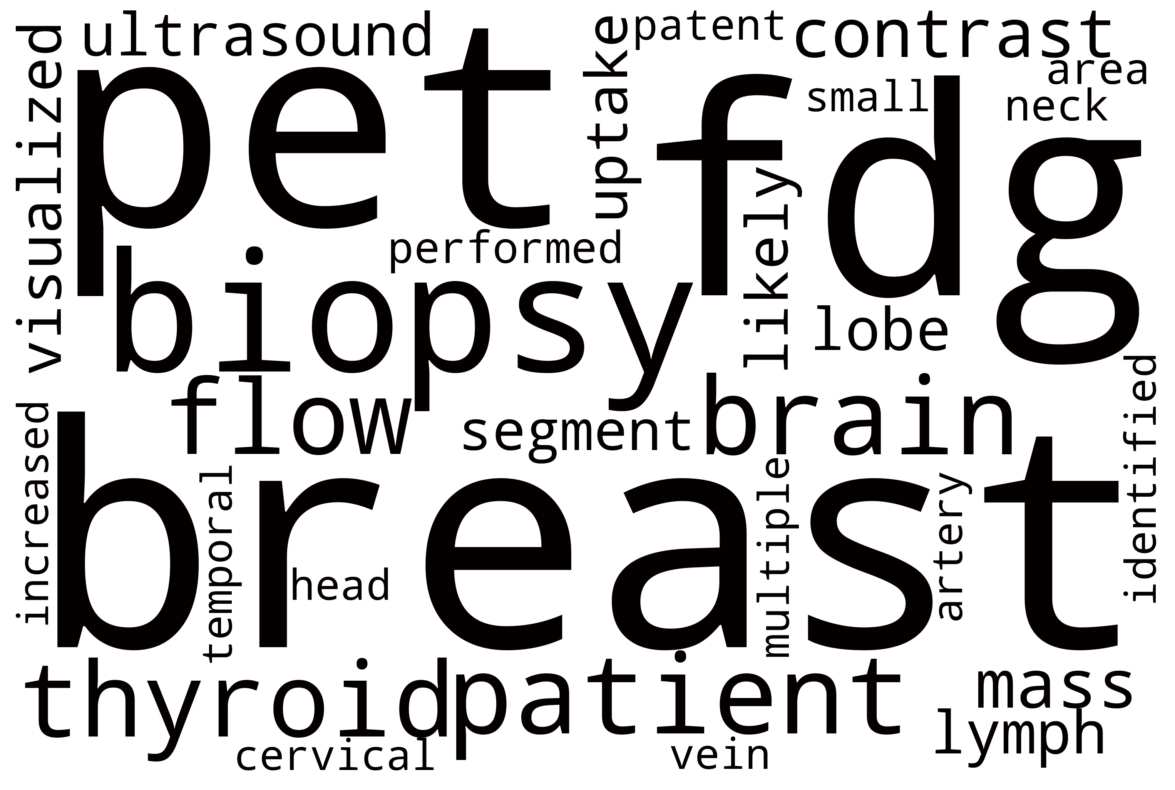

In [1160]:
def black_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%, 1%)")

for i in range(num_clusters):    
    wordcloud = WordCloud(stopwords=STOPWORDS, width=3000, height=2000, background_color="white", max_words=1000).generate_from_frequencies(dict(top_n_words[i]))
    # set the word color to black
    wordcloud.recolor(color_func = black_color_func)# set the figsize
    plt.figure(figsize=[15,10])
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')

## LDA

In [1162]:
from nltk.tokenize import RegexpTokenizer
from sklearn.decomposition import LatentDirichletAllocation

# Initialize regex tokenizer
tokenizer = RegexpTokenizer(r'\w+')

# Vectorize document using TF-IDF
tfidf = TfidfVectorizer(lowercase=True,
                        stop_words='english',
                        ngram_range = (1,1),
                        tokenizer = tokenizer.tokenize)

# Fit and Transform the documents
train_data = tfidf.fit_transform(corpus) 

In [1167]:
# Create LDA object
model=LatentDirichletAllocation(n_components=num_clusters)

# Fit and Transform SVD model on data
lda_matrix = model.fit_transform(train_data)

# Get Components 
lda_components=model.components_

In [1172]:
# Print the topics with their terms
terms = tfidf.get_feature_names()

for index, component in enumerate(lda_components):
    zipped = zip(terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:20]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index)+": ",top_terms_list)

print(top_terms_list)    

Topic 0:  ['fdg', 'order', 'right', 'procedure', 'left', 'impression', 'unchanged', 'pulmonary', 'patient', 'dictation', 'avid', 'small', 'breast', 'lymph', 'pm', 'charge', 'ct', 'pleural', 'goiter', 'fluoro']
Topic 1:  ['intracranial', 'acute', 'ct', 'head', 'white', 'matter', 'hemorrhage', 'brain', 'infarct', 'cerebral', 'mass', 'effect', 'contrast', 'nonspecific', 'chronic', 'loss', 'volume', 'territorial', 'mastoid', 'shift']
Topic 2:  ['impression', 'pm', 'cardiopulmonary', 'left', 'shoulder', 'acute', 'fracture', 'knee', 'right', 'joint', 'disease', 'change', 'views', 'xr', '3', 'dislocation', 'hip', '12', 'prior', '8']
Topic 3:  ['bowel', 'abdomen', 'ct', 'abdominal', 'gas', 'right', 'pelvis', 'free', 'contrast', 'visualized', 'normal', 'colon', 'pattern', 'small', 'kub', 'air', 'hernia', 'stool', 'large', 'lung']
Topic 4:  ['chest', 'view', 'pulmonary', 'pneumothorax', 'normal', 'pleural', 'lung', 'silhouette', 'comparison', 'effusion', 'ray', 'right', 'single', 'cardiac', 'x',